## Project Overview
This project analyzes 10 million user interactions from a multi-category e-commerce platform to understand user behavior and identify opportunities to improve conversion rates. Using exploratory data analysis (EDA), session-level funnel analysis we identify patterns in how users browse and make purchases. These insights can guide product strategy, marketing efforts, and UX design.

## The Dataset
The dataset was originally sourced from [Kaggle](https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store) and includes user interactions over the course of October 2019. Each row represents an event (e.g., view, cart, purchase) performed by a user during a session.

| Feature          | Description                                                                 |
|------------------|-----------------------------------------------------------------------------|
| `event_time`     | Timestamp of the user action (UTC format)                                  |
| `event_type`     | Type of event: `view`, `cart`, `purchase`, or `remove_from_cart`           |
| `product_id`     | Unique product identifier                                                  |
| `category_id`    | Encoded category ID                                                        |
| `category_code`  | Hierarchical category string (e.g., `electronics.smartphone`)              |
| `brand`          | Product brand                                                              |
| `price`          | Price of the product                                                       |
| `user_id`        | Anonymized user ID                                                         |
| `user_session`   | Session ID to group actions by the same user visit                         |

## Key Questions Addressed
- Where are users dropping off in the conversion funnel?
- At what times are users most likely to make purchases?
- Which product categories have the highest conversion rates?

## Tools & Libraries
- **pandas** – data cleaning and manipulation  
- **seaborn**, **matplotlib** – visualizations and plotting  
- **Jupyter Notebook** – interactive analysis and documentation

## Observations and Conclusions
- The largest drop-off occurs between the view and cart stages, indicating a potential need for improved product presentation or stronger calls for action such as limited-time offers.
- Purchases tend to peak during evening hours (7–9 PM) suggesting an ideal window for running targeted promotions.
- Categories like **electronics.smartphone** and **appliances.environment.fan** have the highest view-to-purchase conversion rates, exceeding 10% , making them strong candidates for homepage placement
- Many users don't finish their purchase in one session. Sending reminder emails or using retargeting ads could help bring them back and improve conversion rates.


Start by loading in only a chunk of the data since it is a larger file. 

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(r"E:\Datasets\2019-Oct.csv", nrows=10000000)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 686.6+ MB


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [91]:
# convert time column to datetime
df['event_time'] = pd.to_datetime(df['event_time'])

# add additional features
df['hour'] = df['event_time'].dt.hour
df['weekday'] = df['event_time'].dt.day_name()

df[['event_time', 'hour', 'weekday']].head()

,event_time,hour,weekday
0,2019-10-01 00:00:00+00:00,0,Tuesday
1,2019-10-01 00:00:00+00:00,0,Tuesday
2,2019-10-01 00:00:01+00:00,0,Tuesday
3,2019-10-01 00:00:01+00:00,0,Tuesday
4,2019-10-01 00:00:04+00:00,0,Tuesday


## E-Commerce Funnel Overview

An e-commerce funnel shows the steps a user takes from looking at a product to buying it.

The standard funnel stages are:

1. **View** – A user views a product page.
2. **Cart** – The user adds a product to their cart.
3. **Purchase** – The user completes the purchase.

We measure the **conversion rate** between each stage to quantify how effectively users are moving through the funnel:

- **View → Cart** Conversion Rate: What percentage of viewers add an item to their cart.
- **Cart → Purchase** Conversion Rate: What percentage of users who added to cart go on to purchase.
- **View → Purchase** Conversion Rate: Overall purchase rate from product views.

These metrics are calculated using the number of **unique users** who performed each action.

In [92]:
# count unique users who perform each action
view_users = set(df[df['event_type'] == 'view']['user_id'].unique())
cart_users = set(df[df['event_type'] == 'cart']['user_id'].unique())
purchase_users = set(df[df['event_type'] == 'purchase']['user_id'].unique())

# intersections
view_and_cart = view_users & cart_users
cart_and_purchase = cart_users & purchase_users
view_and_purchase = view_users & purchase_users

# conversion rates using overlap
view_to_cart = len(view_and_cart) / len(view_users)
view_to_purchase = len(view_and_purchase) / len(view_users)
cart_to_purchase = len(cart_and_purchase) / len(cart_users)

print("View to Cart:", round(view_to_cart * 100, 2), "%")
print("View to Purchase:", round(view_to_purchase * 100, 2), "%")
print("Cart to Purchase:", round(cart_to_purchase * 100, 2), "%")

View to Cart: 7.9 %
View to Purchase: 9.39 %
Cart to Purchase: 59.04 %


Overlap is accounted for the uses who never added to the cart before purchasing. 

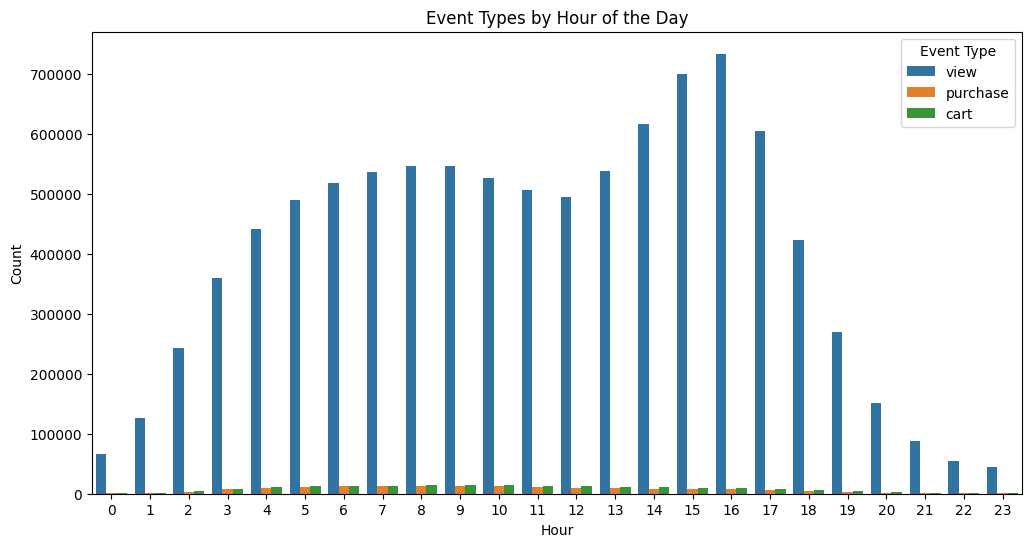

In [93]:
plt.figure(figsize=(12,6))

sns.countplot(data=df, 
              x='hour', 
              hue='event_type', 
              order=range(24))
plt.title("Event Types by Hour of the Day")
plt.ylabel("Count")
plt.xlabel("Hour")
plt.legend(title="Event Type")
plt.show()

In [94]:
session_funnels = df.groupby('user_session')['event_type'].apply(set)
funnel_patterns = session_funnels.value_counts().head(10)
funnel_patterns

event_type
{view}                    1944911
{purchase, view}            83359
{cart, purchase, view}      62403
{cart, view}                57712
{cart}                        156
{purchase}                    147
{cart, purchase}               77
Name: count, dtype: int64

In [95]:
funnel_percentages = funnel_patterns / funnel_patterns.sum()
funnel_percentages

event_type
{view}                    0.905130
{purchase, view}          0.038794
{cart, purchase, view}    0.029041
{cart, view}              0.026858
{cart}                    0.000073
{purchase}                0.000068
{cart, purchase}          0.000036
Name: count, dtype: float64

Text(0, 0.5, 'Funnel Path')

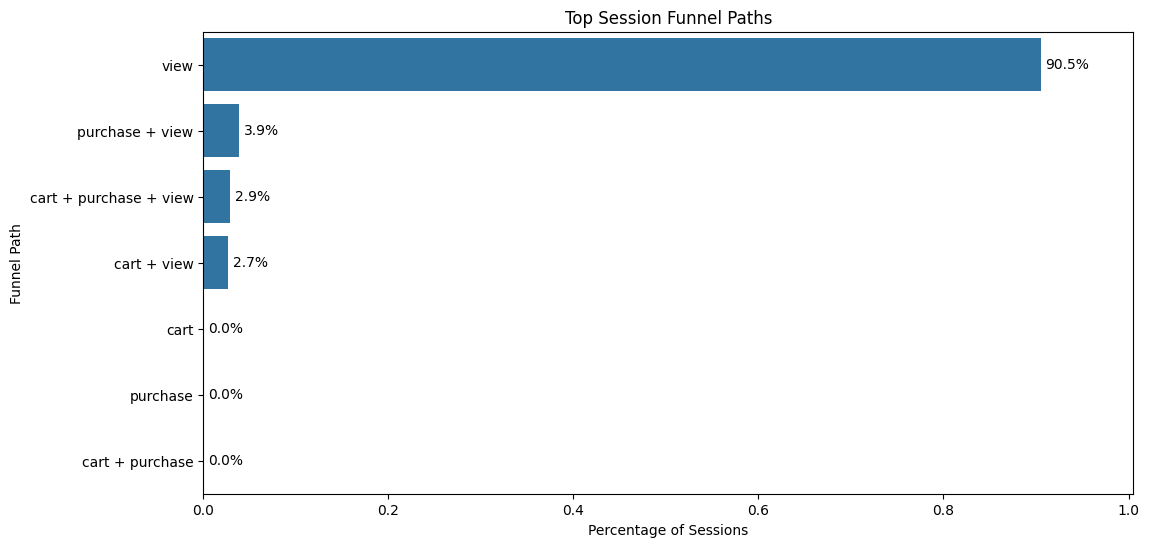

In [96]:
funnel_df = funnel_percentages.reset_index()
funnel_df = funnel_df.rename(columns={'event_type': "funnel_path",
                          'count': "percentage"})
funnel_df['funnel_path'] = funnel_df['funnel_path'].apply(lambda x: ' + '.join(sorted(x)))
funnel_df = funnel_df.sort_values('percentage', ascending=False)

plt.figure(figsize=(12,6))

barplot = sns.barplot(data=funnel_df,
            y='funnel_path',
            x='percentage')

# percentage labels
for i, bar in enumerate(barplot.patches):
    value = funnel_df.iloc[i]['percentage']
    barplot.text(
        bar.get_width() + 0.005,
        bar.get_y() + bar.get_height() / 2,
        f"{value:.1%}",
        ha='left', va='center', color='black', fontsize=10
    )

plt.xlim(0, funnel_df['percentage'].max() + 0.10)
plt.title("Top Session Funnel Paths")
plt.xlabel("Percentage of Sessions")
plt.ylabel("Funnel Path")

## Breaking down Product Funnels by Category

In [97]:
category_funnel = df.groupby(['category_code', 'event_type'])['user_id'].nunique().unstack().fillna(0)
category_funnel['view_to_cart'] = category_funnel['cart'] / category_funnel['view']
category_funnel['cart_to_purchase'] = category_funnel['purchase'] / category_funnel['cart']
category_funnel['view_to_purchase'] = category_funnel['purchase'] / category_funnel['view']
category_funnel = category_funnel.sort_values('view_to_purchase', ascending=False)

C:\Users\mqtth\AppData\Local\Temp\ipykernel_36836\3164882327.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


(0.0, 0.13212640628705982)

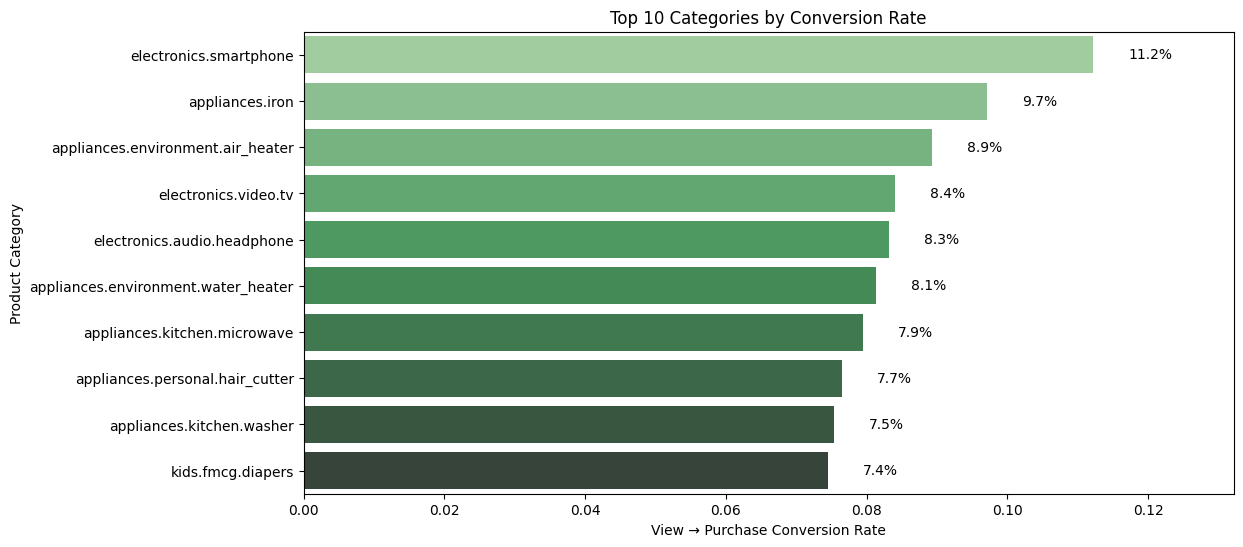

In [98]:
top_cats = category_funnel.head(10).reset_index()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=top_cats, 
    x='view_to_purchase', 
    y='category_code', 
    palette='Greens_d'
)

# percentage labels
for i, bar in enumerate(barplot.patches):
    value = top_cats.iloc[i]['view_to_purchase']
    barplot.text(
        bar.get_width() + 0.005,
        bar.get_y() + bar.get_height() / 2,
        f"{value:.1%}",
        ha='left', va='center', color='black', fontsize=10
    )

plt.xlabel('View → Purchase Conversion Rate')
plt.ylabel('Product Category')
plt.title('Top 10 Categories by Conversion Rate')
plt.xlim(0, top_cats['view_to_purchase'].max() + 0.02)


This chart shows the top 10 product categories ranked by their view-to-purchase conversion rate which is the percentage of users who viewed a product and completed a purchase. Categories such as electronics.smartphone and appliances.environment.fan have high conversion rates, with more than 10% of viewers making a purchase. This suggests that smartphones are either well-presented on the site or in high demand, which intuitively makes sense. 

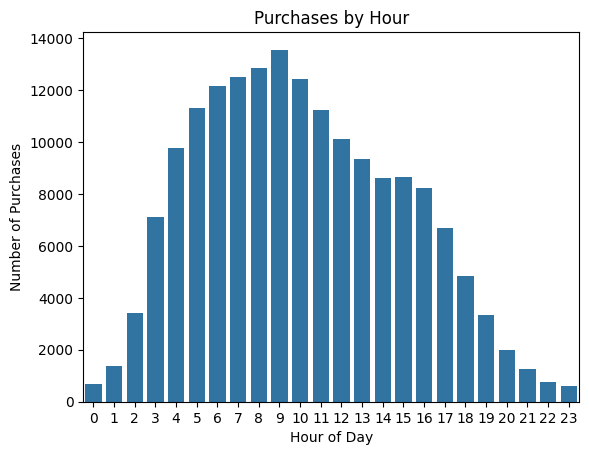

In [99]:
df['event_time'] = pd.to_datetime(df['event_time'])
df['hour'] = df['event_time'].dt.hour
purchase_df = df[df['event_type'] == 'purchase']

sns.countplot(x='hour', data=purchase_df)
plt.title('Purchases by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Purchases')
plt.show()